# 3戦略ミニマル比較（Full Code Notebook）

目的:
- `T1_best_onoff_statepred_M12_eta0p2`（Full Spec推奨）
- `T1_mom`（No-overlay基準）
- `EQW`（等ウェイト基準）

を最小構成で比較する。

比較対象:
1. NAV時系列
2. 各時点のウェイト
3. パフォーマンス（Train/Test/All）
4. 寄与分析（factor / internal / overlay）

主要式:
- Overlayスケール: `scale_t = \eta + (1-\eta) I_t`
- managed score: `S^{managed}_{i,t} = scale_t S_{i,t}`
- factor寄与: `contrib_{s,j,t} = eta_{s,j,t} f_{j,t}`
- internal寄与: `R^{wgt}_t = R^{port}_t - R^{sel}_t`


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import math
import os


def _find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "docs" / "notes" / "01_universe.csv").exists() and (candidate / "data").exists():
            return candidate
    raise FileNotFoundError("プロジェクトルートが見つかりません（docs/notes/01_universe.csv）")


PROJECT_ROOT = _find_project_root(Path.cwd()).resolve()
(PROJECT_ROOT / "outputs" / "logs" / "matplotlib").mkdir(parents=True, exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(PROJECT_ROOT / "outputs" / "logs" / "matplotlib"))

import matplotlib
try:
    from IPython import get_ipython
except Exception:  # noqa: BLE001
    def get_ipython():
        return None
if get_ipython() is None:
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

try:
    from IPython.display import display
except Exception:  # noqa: BLE001
    def display(x):
        print(x)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 220)


In [2]:
# ============================================================
# 設定・定数
# ============================================================
INVESTABLE_TICKERS = [
    "AIQ", "BOTZ", "SMH", "WCLD", "CIBR", "IPAY", "ICLN", "TAN", "DRIV",
    "LIT", "UFO", "ITA", "ARKG", "PHO", "MOO", "PAVE", "ESPO", "KOMP",
]

FACTOR_TICKERS = ["SPY", "QQQ", "IEF"]


def resolve_path_from_root(root: Path, relative: str, must_exist: bool = True) -> Path:
    rel = Path(relative)
    for candidate_root in [root, *root.parents]:
        candidate = candidate_root / rel
        if candidate.exists():
            return candidate
    fallback = root / rel
    if must_exist:
        raise FileNotFoundError(f"required path not found: {relative} (start={root})")
    return fallback


@dataclass
class Config:
    start_date: str = "2015-01-01"
    end_date: str | None = None
    split_date: str = "2021-01-01"

    top_k: int = 4
    rebalance: str = "M"
    exec_lag: int = 1
    lookback_price: int = 252

    fee_bps: float = 10.0
    slippage_bps: float = 1.0

    # Full Spec ON/OFF StepB default
    onoff_eta: float = 0.2
    onoff_target_m: int = 12
    onoff_min_train: int = 36
    onoff_use_vol_norm: bool = True

    root: Path = Path(".").resolve()

    @property
    def universe_csv(self) -> Path:
        return resolve_path_from_root(self.root, "docs/notes/01_universe.csv", must_exist=True)

    @property
    def raw_dir(self) -> Path:
        return resolve_path_from_root(self.root, "data/raw", must_exist=False)


# ============================================================
# データユーティリティ
# ============================================================
def parse_expense_ratio(value: object) -> float:
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return float("nan")
    text = str(value).strip()
    if not text:
        return float("nan")
    if text.endswith("%"):
        try:
            return float(text[:-1]) / 100.0
        except ValueError:
            return float("nan")
    try:
        parsed = float(text)
    except ValueError:
        return float("nan")
    return parsed / 100.0 if parsed > 1.0 else parsed


def load_universe(cfg: Config) -> pd.DataFrame:
    universe_path = cfg.universe_csv
    universe = pd.read_csv(universe_path)
    universe["ticker"] = universe["ticker"].astype(str).str.upper().str.strip()
    universe = universe.drop_duplicates(subset=["ticker"]).set_index("ticker", drop=False)

    missing = sorted(set(INVESTABLE_TICKERS) - set(universe.index))
    if missing:
        raise ValueError(f"universe csv missing tickers: {missing}")

    universe = universe.loc[INVESTABLE_TICKERS].copy()
    universe["expense_ratio_dec"] = universe["expense_ratio"].apply(parse_expense_ratio)
    return universe


def _read_csv_idx(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.sort_index()
    df.columns = [str(c) for c in df.columns]
    return df


def _extract_field(raw: pd.DataFrame, tickers: list[str], field: str) -> pd.DataFrame:
    if raw.empty:
        return pd.DataFrame(columns=tickers)
    if isinstance(raw.columns, pd.MultiIndex):
        if field not in raw.columns.get_level_values(0):
            return pd.DataFrame(index=raw.index, columns=tickers, dtype=float)
        out = raw[field].copy()
        if isinstance(out, pd.Series):
            out = out.to_frame(name=tickers[0])
        return out.reindex(columns=tickers)
    if field not in raw.columns:
        return pd.DataFrame(index=raw.index, columns=tickers, dtype=float)
    out = raw[field]
    if isinstance(out, pd.Series):
        return out.to_frame(name=tickers[0])
    out = out.copy()
    out.columns = tickers[: out.shape[1]]
    return out


def download_price_volume(tickers: list[str], start: str, end: str | None) -> tuple[pd.DataFrame, pd.DataFrame]:
    if not tickers:
        idx = pd.DatetimeIndex([], name="Date")
        return pd.DataFrame(index=idx), pd.DataFrame(index=idx)

    raw = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval="1d",
        auto_adjust=False,
        actions=False,
        progress=False,
        group_by="column",
        threads=False,
    )
    adj = _extract_field(raw, tickers, "Adj Close")
    vol = _extract_field(raw, tickers, "Volume")

    adj.index = pd.to_datetime(adj.index).tz_localize(None)
    vol.index = pd.to_datetime(vol.index).tz_localize(None)

    adj = adj.loc[:, ~adj.columns.duplicated()].reindex(columns=tickers).astype(float)
    vol = vol.loc[:, ~vol.columns.duplicated()].reindex(columns=tickers).astype(float)
    return adj, vol


def compute_first_valid_dates(adj_close: pd.DataFrame) -> pd.Series:
    return pd.Series({c: adj_close[c].first_valid_index() for c in adj_close.columns}, name="first_valid_date")


def build_investable_mask(adj_close: pd.DataFrame, first_valid: pd.Series) -> pd.DataFrame:
    mask = pd.DataFrame(False, index=adj_close.index, columns=adj_close.columns)
    for ticker in adj_close.columns:
        start = first_valid.get(ticker)
        if pd.isna(start) or start is None:
            continue
        mask.loc[mask.index >= pd.Timestamp(start), ticker] = True
    return mask


def compute_returns(adj_close: pd.DataFrame, mask: pd.DataFrame) -> pd.DataFrame:
    ret = adj_close.pct_change(fill_method=None)
    return ret.where(mask)


def load_or_prepare_data(cfg: Config) -> dict[str, pd.DataFrame | pd.Series]:
    cfg.raw_dir.mkdir(parents=True, exist_ok=True)
    p_adj = cfg.raw_dir / "investable_adj_close.csv"
    p_vol = cfg.raw_dir / "investable_volume.csv"
    p_fac = cfg.raw_dir / "factor_adj_close_minimal_3.csv"

    if p_adj.exists() and p_vol.exists() and p_fac.exists():
        adj = _read_csv_idx(p_adj).reindex(columns=INVESTABLE_TICKERS)
        vol = _read_csv_idx(p_vol).reindex(columns=INVESTABLE_TICKERS)
        fac = _read_csv_idx(p_fac).reindex(columns=FACTOR_TICKERS)
    else:
        adj, vol = download_price_volume(INVESTABLE_TICKERS, cfg.start_date, cfg.end_date)
        fac, _ = download_price_volume(FACTOR_TICKERS, cfg.start_date, cfg.end_date)
        adj.to_csv(p_adj)
        vol.to_csv(p_vol)
        fac.to_csv(p_fac)

    first_valid = compute_first_valid_dates(adj)
    mask = build_investable_mask(adj, first_valid)
    ret = compute_returns(adj, mask)

    factor_ret = fac.pct_change(fill_method=None).reindex(columns=FACTOR_TICKERS)
    eqw_factor = ret.where(mask).mean(axis=1, skipna=True).rename("EQW")

    return {
        "adj_close": adj,
        "volume": vol,
        "returns": ret,
        "investable_mask": mask,
        "first_valid_dates": first_valid,
        "factor_returns": factor_ret,
        "eqw_factor": eqw_factor,
    }


In [3]:
# ============================================================
# シグナル / ON-OFF StepB
# ============================================================
def _cross_sectional_zscore(frame: pd.DataFrame, mask: pd.DataFrame) -> pd.DataFrame:
    masked = frame.where(mask)
    mu = masked.mean(axis=1, skipna=True)
    sd = masked.std(axis=1, skipna=True).replace(0.0, np.nan)
    return masked.sub(mu, axis=0).div(sd, axis=0)


def compute_t1_mom_score(
    adj_close: pd.DataFrame,
    investable_mask: pd.DataFrame,
    lookback: int,
    exec_lag: int,
) -> pd.DataFrame:
    lagged = adj_close.shift(exec_lag)
    base = adj_close.shift(exec_lag + lookback)
    trend = lagged.div(base).sub(1.0)
    score = _cross_sectional_zscore(trend, investable_mask)
    return score.where(investable_mask)


def apply_onoff_overlay(scores: pd.DataFrame, indicator: pd.Series, eta: float) -> pd.DataFrame:
    ind = indicator.reindex(scores.index).fillna(0.0).astype(float)
    scale = eta + (1.0 - eta) * ind
    return scores.mul(scale, axis=0)


def _normalize_weights(weights: pd.DataFrame) -> pd.DataFrame:
    row_sum = weights.sum(axis=1)
    return weights.div(row_sum.where(row_sum > 0.0), axis=0).fillna(0.0)


def _build_topk_weights(scores: pd.DataFrame, top_k: int) -> pd.DataFrame:
    w = pd.DataFrame(0.0, index=scores.index, columns=scores.columns)
    for dt in scores.index:
        row = scores.loc[dt].dropna().sort_values(ascending=False)
        if row.empty:
            continue
        sel = row.head(top_k).index
        w.loc[dt, sel] = 1.0 / len(sel)
    return w


def _to_monthly_compound(daily: pd.Series) -> pd.Series:
    m = (1.0 + daily.fillna(0.0)).groupby(daily.index.to_period("M")).prod() - 1.0
    m.index = m.index.to_timestamp("M")
    return m


def _to_monthly_last(daily: pd.Series) -> pd.Series:
    m = daily.groupby(daily.index.to_period("M")).last()
    m.index = m.index.to_timestamp("M")
    return m


def compute_sed(y_true: pd.Series, y_pred: pd.Series, demean: bool = True) -> pd.Series:
    aligned = pd.concat([y_true.rename("y_true"), y_pred.rename("y_pred")], axis=1).dropna(how="all")
    sed = aligned["y_true"].fillna(0.0) - aligned["y_pred"].fillna(0.0)
    if demean:
        sed = sed - sed.expanding(min_periods=1).mean()
    sed.name = "sed"
    return sed


def _derive_base_and_benchmark_returns(
    base_scores: pd.DataFrame,
    future_returns: pd.DataFrame,
    top_k: int,
    exec_lag: int,
) -> tuple[pd.Series, pd.Series]:
    score = base_scores.reindex(index=future_returns.index, columns=future_returns.columns)
    w_target = _build_topk_weights(score, top_k=top_k)
    w_exec = w_target.shift(exec_lag).ffill().fillna(0.0)

    avail = future_returns.notna()
    eff_w = _normalize_weights(w_exec.where(avail, 0.0))

    base_ret = (eff_w * future_returns).sum(axis=1, min_count=1).fillna(0.0)
    eqw_ret = future_returns.mean(axis=1, skipna=True).fillna(0.0)
    return base_ret.rename("base_ret"), eqw_ret.rename("eqw_ret")


def _build_state_pred_dataset(
    base_scores: pd.DataFrame,
    future_returns: pd.DataFrame,
    factor_returns: pd.DataFrame,
    top_k: int,
    exec_lag: int,
    target_m: int,
    use_vol_norm: bool,
    demean: bool,
) -> dict[str, pd.DataFrame | pd.Series]:
    base_daily, eqw_daily = _derive_base_and_benchmark_returns(
        base_scores=base_scores,
        future_returns=future_returns,
        top_k=top_k,
        exec_lag=exec_lag,
    )

    base_m = _to_monthly_compound(base_daily)
    eqw_m = _to_monthly_compound(eqw_daily)
    sed_m = compute_sed(base_m, eqw_m, demean=demean).rename("sed_m")
    sed_target = sed_m.rolling(target_m, min_periods=max(2, target_m // 2)).mean().rename("sed_target")

    vol_mkt = eqw_m.rolling(12, min_periods=6).std().rename("vol_mkt")
    y = (sed_target / vol_mkt.replace(0.0, np.nan)).rename("y") if use_vol_norm else sed_target.rename("y")

    feat = pd.DataFrame(index=sed_target.index)
    feat["SED_lag1"] = sed_target.shift(1)
    feat["SED_lag3"] = sed_target.shift(3)
    feat["SED_lag6"] = sed_target.shift(6)
    feat["SED_lag12"] = sed_target.shift(12)
    feat["EQW_ret_lag1"] = eqw_m.shift(1)
    feat["EQW_ret_lag3"] = eqw_m.rolling(3, min_periods=3).sum().shift(1)
    feat["RV_EQW_12m_lag1"] = vol_mkt.shift(1)

    csvar_daily = future_returns.var(axis=1, skipna=True)
    feat["CSVAR_lag1"] = _to_monthly_last(csvar_daily).reindex(feat.index).shift(1)

    disp_daily = base_scores.std(axis=1, skipna=True)
    feat["DISP_lag1"] = _to_monthly_last(disp_daily).reindex(feat.index).shift(1)

    if not factor_returns.empty:
        f_m = factor_returns.groupby(factor_returns.index.to_period("M")).apply(
            lambda x: (1.0 + x.fillna(0.0)).prod() - 1.0
        )
        if isinstance(f_m.index, pd.MultiIndex):
            f_m.index = f_m.index.get_level_values(0)
        f_m.index = pd.PeriodIndex(f_m.index, freq="M").to_timestamp("M")
        if "SPY" in f_m.columns:
            feat["SPY_ret_lag1"] = f_m["SPY"].reindex(feat.index).shift(1)
        if "IEF" in f_m.columns:
            feat["IEF_ret_lag1"] = f_m["IEF"].reindex(feat.index).shift(1)

    return {
        "base_daily": base_daily,
        "eqw_daily": eqw_daily,
        "base_m": base_m,
        "eqw_m": eqw_m,
        "sed_m": sed_m,
        "sed_target": sed_target,
        "vol_mkt": vol_mkt,
        "y": y,
        "features": feat,
    }


def _fit_ols(x_train: np.ndarray, y_train: np.ndarray, x_pred: np.ndarray) -> tuple[float, np.ndarray]:
    x = np.column_stack([np.ones(len(x_train)), x_train])
    beta, *_ = np.linalg.lstsq(x, y_train, rcond=None)
    y_hat = float(np.concatenate([[1.0], x_pred]) @ beta)
    return y_hat, beta.astype(float)


def _run_expanding_state_pred(
    y: pd.Series,
    features: pd.DataFrame,
    vol_mkt: pd.Series,
    target_m: int,
    min_train: int,
    use_vol_norm: bool,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    y_hat = pd.Series(np.nan, index=y.index, name="y_hat")
    sed_hat = pd.Series(np.nan, index=y.index, name="sed_hat")
    ind = pd.Series(0.0, index=y.index, name="indicator")

    coef_rows: list[dict[str, object]] = []

    for t in range(min_train, len(y.index)):
        y_train = y.iloc[:t]
        x_train_full = features.iloc[:t].copy()
        x_pred_full = features.iloc[t : t + 1].copy()

        train = pd.concat([x_train_full, y_train.rename("y")], axis=1).dropna(subset=["y"])
        if train.empty:
            continue

        feat_cols = [c for c in x_train_full.columns if train[c].notna().sum() >= max(12, min_train // 3)]
        if not feat_cols:
            continue

        x_train = train[feat_cols].copy()
        med = x_train.median()
        x_train = x_train.fillna(med)
        y_train_np = train["y"].to_numpy(dtype=float)

        x_pred = x_pred_full[feat_cols].copy().fillna(med)
        if x_pred.isna().all(axis=1).iloc[0]:
            continue

        pred, beta = _fit_ols(
            x_train=x_train.to_numpy(dtype=float),
            y_train=y_train_np,
            x_pred=x_pred.iloc[0].to_numpy(dtype=float),
        )

        dt = y.index[t]
        y_hat.iloc[t] = pred
        if use_vol_norm:
            sed_hat.iloc[t] = pred * float(vol_mkt.iloc[t]) if pd.notna(vol_mkt.iloc[t]) else np.nan
        else:
            sed_hat.iloc[t] = pred
        ind.iloc[t] = float(sed_hat.iloc[t] > 0.0) if pd.notna(sed_hat.iloc[t]) else 0.0

        coef_rows.append({"date": dt, "coef_name": "intercept", "coef_value": float(beta[0]), "M": int(target_m)})
        for j, c in enumerate(feat_cols, start=1):
            coef_rows.append({"date": dt, "coef_name": c, "coef_value": float(beta[j]), "M": int(target_m)})

    pred_df = pd.DataFrame({"y": y, "y_hat": y_hat, "sed_hat": sed_hat, "indicator": ind.fillna(0.0), "M": int(target_m)}, index=y.index)
    pred_df.index.name = "date"
    coef_df = pd.DataFrame(coef_rows)
    return pred_df, coef_df


def compute_onoff_indicator_statepred(
    dates: pd.DatetimeIndex,
    base_scores: pd.DataFrame,
    future_returns: pd.DataFrame,
    factor_returns: pd.DataFrame,
    *,
    top_k: int,
    exec_lag: int,
    target_m: int,
    min_train: int,
    use_vol_norm: bool,
    demean: bool = True,
) -> pd.DataFrame:
    idx = pd.DatetimeIndex(dates)

    base_ret, eqw_ret = _derive_base_and_benchmark_returns(
        base_scores=base_scores,
        future_returns=future_returns,
        top_k=top_k,
        exec_lag=exec_lag,
    )
    aligned = pd.concat([base_ret, eqw_ret], axis=1).reindex(idx)

    sed_raw = (aligned["base_ret"].fillna(0.0) - aligned["eqw_ret"].fillna(0.0)).rename("sed_raw")
    sed_demeaned = compute_sed(aligned["base_ret"], aligned["eqw_ret"], demean=demean).reindex(idx)

    ds = _build_state_pred_dataset(
        base_scores=base_scores,
        future_returns=future_returns,
        factor_returns=factor_returns,
        top_k=top_k,
        exec_lag=exec_lag,
        target_m=target_m,
        use_vol_norm=use_vol_norm,
        demean=demean,
    )

    pred_m, coef_df = _run_expanding_state_pred(
        y=ds["y"],
        features=ds["features"],
        vol_mkt=ds["vol_mkt"],
        target_m=target_m,
        min_train=min_train,
        use_vol_norm=use_vol_norm,
    )

    month_key = idx.to_period("M").to_timestamp("M")
    sed_pred = pred_m["sed_hat"].reindex(month_key).set_axis(idx)
    indicator = pred_m["indicator"].reindex(month_key).set_axis(idx).fillna(0.0)

    out = pd.DataFrame(
        {
            "sed_raw": sed_raw.reindex(idx),
            "sed_demeaned": sed_demeaned.reindex(idx),
            "sed_pred": sed_pred.reindex(idx),
            "indicator": indicator,
        },
        index=idx,
    )
    out.index.name = "date"
    out.attrs["stepb_features"] = ds["features"]
    out.attrs["stepb_pred"] = pred_m
    out.attrs["stepb_coef"] = coef_df
    return out


In [4]:
# ============================================================
# ポートフォリオ / バックテスト
# ============================================================
def make_rebalance_mask(index: pd.DatetimeIndex, freq: str = "M") -> pd.Series:
    periods = index.to_period(freq)
    mask = periods != periods.shift(-1)
    return pd.Series(mask, index=index, name="rebalance_mask").astype(bool)


def build_target_weights(
    score: pd.DataFrame,
    investable_mask: pd.DataFrame,
    top_k: int,
    rebalance_freq: str = "M",
) -> tuple[pd.DataFrame, pd.Series]:
    rebalance_mask = make_rebalance_mask(score.index, freq=rebalance_freq)
    target = pd.DataFrame(np.nan, index=score.index, columns=score.columns)

    for dt in score.index[rebalance_mask]:
        row_s = score.loc[dt]
        eligible = investable_mask.loc[dt] & row_s.notna()
        valid = row_s.where(eligible).dropna().sort_values(ascending=False)

        row_w = pd.Series(0.0, index=score.columns)
        if not valid.empty:
            sel = valid.head(top_k).index
            row_w.loc[sel] = 1.0 / len(sel)

        target.loc[dt] = row_w

    holdings = target.ffill().fillna(0.0)
    holdings = holdings.where(investable_mask, 0.0)
    return _normalize_weights(holdings), rebalance_mask


def _build_eqw_holdings(index: pd.DatetimeIndex, investable_mask: pd.DataFrame, rebalance_freq: str) -> pd.DataFrame:
    rebalance_mask = make_rebalance_mask(index, freq=rebalance_freq)
    target = pd.DataFrame(index=index, columns=investable_mask.columns, dtype=float)

    for dt in index[rebalance_mask]:
        eligible = investable_mask.loc[dt]
        row = pd.Series(0.0, index=investable_mask.columns)
        n = int(eligible.sum())
        if n > 0:
            row.loc[eligible[eligible].index] = 1.0 / n
        target.loc[dt] = row

    h = target.ffill().fillna(0.0)
    h = h.where(investable_mask, 0.0)
    return _normalize_weights(h)


def _compute_portfolio_path(
    holdings: pd.DataFrame,
    returns: pd.DataFrame,
    expense_ratio: pd.Series,
    fee_bps: float,
    slippage_bps: float,
) -> dict[str, pd.Series | pd.DataFrame]:
    h = holdings.fillna(0.0)
    r = returns.copy()

    available = r.notna()
    eff_h = _normalize_weights(h.where(available, 0.0))

    gross = (eff_h * r).sum(axis=1)

    prev = h.shift(1).fillna(0.0)
    turnover = (h - prev).abs().sum(axis=1)

    trading = turnover * (fee_bps + slippage_bps) / 10000.0
    expense = (eff_h * (expense_ratio.reindex(h.columns).fillna(0.0) / 252.0)).sum(axis=1)

    net = gross - trading - expense
    nav = (1.0 + net.fillna(0.0)).cumprod()

    return {
        "gross_returns": gross,
        "net_returns": net,
        "nav": nav,
        "turnover": turnover,
        "trading_cost": trading,
        "expense_cost": expense,
        "effective_holdings": eff_h,
    }


def run_backtest(
    target_weights: pd.DataFrame,
    returns: pd.DataFrame,
    investable_mask: pd.DataFrame,
    expense_ratio: pd.Series,
    fee_bps: float,
    slippage_bps: float,
    exec_lag: int,
    rebalance_freq: str,
) -> dict[str, pd.Series | pd.DataFrame]:
    exec_w = target_weights.shift(exec_lag).ffill().fillna(0.0)
    exec_w = exec_w.where(investable_mask, 0.0)
    exec_w = _normalize_weights(exec_w)

    strat = _compute_portfolio_path(
        holdings=exec_w,
        returns=returns,
        expense_ratio=expense_ratio,
        fee_bps=fee_bps,
        slippage_bps=slippage_bps,
    )

    eqw_w = _build_eqw_holdings(returns.index, investable_mask, rebalance_freq)
    eqw = _compute_portfolio_path(
        holdings=eqw_w,
        returns=returns,
        expense_ratio=expense_ratio,
        fee_bps=fee_bps,
        slippage_bps=slippage_bps,
    )

    return {
        "target_weights": target_weights,
        "executed_weights": exec_w,
        "strategy_effective_holdings": strat["effective_holdings"],
        "strategy_nav": strat["nav"],
        "strategy_net_returns": strat["net_returns"],
        "strategy_gross_returns": strat["gross_returns"],
        "strategy_turnover": strat["turnover"],
        "strategy_trading_cost": strat["trading_cost"],
        "strategy_expense_cost": strat["expense_cost"],
        "eqw_weights": eqw_w,
        "eqw_effective_holdings": eqw["effective_holdings"],
        "eqw_nav": eqw["nav"],
        "eqw_net_returns": eqw["net_returns"],
        "eqw_turnover": eqw["turnover"],
        "eqw_trading_cost": eqw["trading_cost"],
        "eqw_expense_cost": eqw["expense_cost"],
    }


In [5]:
# ============================================================
# 指標 / 寄与分析
# ============================================================
def annualized_return(nav: pd.Series) -> float:
    nav = nav.dropna()
    if nav.empty:
        return np.nan
    years = len(nav) / 252.0
    return float(nav.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan


def annualized_vol(returns: pd.Series) -> float:
    r = returns.dropna()
    if len(r) < 2:
        return np.nan
    return float(r.std(ddof=1) * np.sqrt(252.0))


def sharpe(returns: pd.Series) -> float:
    r = returns.dropna()
    if len(r) < 2:
        return np.nan
    sd = r.std(ddof=1)
    if np.isclose(sd, 0.0):
        return np.nan
    return float((r.mean() / sd) * np.sqrt(252.0))


def max_drawdown(nav: pd.Series) -> float:
    nav = nav.dropna()
    if nav.empty:
        return np.nan
    dd = nav / nav.cummax() - 1.0
    return float(dd.min())


def _slice(series: pd.Series, start: pd.Timestamp | None, end: pd.Timestamp | None) -> pd.Series:
    if start is not None and end is not None:
        return series.loc[(series.index >= start) & (series.index < end)]
    if start is not None:
        return series.loc[series.index >= start]
    if end is not None:
        return series.loc[series.index < end]
    return series


def summarize_period(net_ret: pd.Series, nav: pd.Series, turnover: pd.Series, trading: pd.Series, expense: pd.Series) -> dict[str, float]:
    return {
        "CAGR": annualized_return(nav),
        "Sharpe": sharpe(net_ret),
        "Vol": annualized_vol(net_ret),
        "MDD": max_drawdown(nav),
        "AvgTurnover": float(turnover.dropna().mean()) if not turnover.dropna().empty else np.nan,
        "TotalTradingCost": float(trading.dropna().sum()) if not trading.dropna().empty else np.nan,
        "TotalExpenseCost": float(expense.dropna().sum()) if not expense.dropna().empty else np.nan,
        "TotalCost": float(trading.dropna().sum() + expense.dropna().sum()) if (not trading.dropna().empty and not expense.dropna().empty) else np.nan,
        "FinalNAV": float(nav.dropna().iloc[-1]) if not nav.dropna().empty else np.nan,
    }


def performance_table_for_strategy(
    strategy_id: str,
    net_ret: pd.Series,
    nav: pd.Series,
    turnover: pd.Series,
    trading: pd.Series,
    expense: pd.Series,
    split_date: str,
) -> pd.DataFrame:
    split = pd.Timestamp(split_date)
    defs = {
        "All": (None, None),
        "Train": (None, split),
        "Test": (split, None),
    }
    rows = []
    for p, (st, ed) in defs.items():
        row = summarize_period(
            _slice(net_ret, st, ed),
            _slice(nav, st, ed),
            _slice(turnover, st, ed),
            _slice(trading, st, ed),
            _slice(expense, st, ed),
        )
        row["strategy_id"] = strategy_id
        row["period"] = p
        rows.append(row)
    return pd.DataFrame(rows)


def make_monthly_returns_from_nav(nav: pd.Series) -> pd.Series:
    me = nav.groupby(nav.index.to_period("M")).last()
    me.index = me.index.to_timestamp("M")
    return me.pct_change(fill_method=None)


def rolling_factor_attribution(
    returns_by_strategy: pd.DataFrame,
    factor_returns: pd.DataFrame,
    window_months: int,
    lag: int = 1,
    min_obs: int | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    common = returns_by_strategy.index.intersection(factor_returns.index)
    y_all = returns_by_strategy.loc[common].sort_index()
    f_all = factor_returns.loc[common].sort_index()

    min_obs = min_obs or max(24, window_months // 2)
    fac_names = list(f_all.columns)

    beta_rows = []
    contrib_rows = []
    alpha_rows = []

    for sid in y_all.columns:
        y = y_all[sid]
        for pos in range(window_months + lag, len(common)):
            t = common[pos]
            end_train = pos - lag
            start_train = end_train - window_months + 1
            if start_train < 0:
                continue

            y_train = y.iloc[start_train : end_train + 1]
            f_train = f_all.iloc[start_train : end_train + 1]
            train = pd.concat([y_train.rename("y"), f_train], axis=1).dropna()
            if len(train) < min_obs:
                continue

            x = train[fac_names].to_numpy(dtype=float)
            y_np = train["y"].to_numpy(dtype=float)
            x_i = np.column_stack([np.ones(len(x)), x])
            coef, *_ = np.linalg.lstsq(x_i, y_np, rcond=None)
            alpha = float(coef[0])
            beta = coef[1:].astype(float)

            f_t = f_all.loc[t, fac_names]
            y_t = y.loc[t]
            if pd.isna(y_t) or f_t.isna().any():
                continue

            y_hat_t = alpha + float(np.dot(beta, f_t.to_numpy(dtype=float)))
            resid_t = float(y_t - y_hat_t)

            for j, fac in enumerate(fac_names):
                beta_rows.append({"date": t, "strategy_id": sid, "factor_name": fac, "beta": float(beta[j])})
                contrib_rows.append({"date": t, "strategy_id": sid, "factor_name": fac, "contrib": float(beta[j] * float(f_t[fac]))})

            alpha_rows.append({"date": t, "strategy_id": sid, "alpha": alpha, "resid": resid_t})

    betas = pd.DataFrame(beta_rows)
    contrib = pd.DataFrame(contrib_rows)
    alpha_df = pd.DataFrame(alpha_rows)

    resid_rows = []
    if not alpha_df.empty:
        for sid, g in alpha_df.sort_values("date").groupby("strategy_id"):
            rs = g["resid"].astype(float)
            rm = rs.shift(1).rolling(window_months, min_periods=max(12, window_months // 3)).mean()
            rv = rs.shift(1).rolling(window_months, min_periods=max(12, window_months // 3)).std()
            rsh = (rm / rv).replace([np.inf, -np.inf], np.nan) * np.sqrt(12.0)
            t = g.copy()
            t["resid_rolling_sharpe"] = rsh.values
            resid_rows.append(t[["date", "strategy_id", "resid", "resid_rolling_sharpe"]])
    resid_stats = pd.concat(resid_rows, ignore_index=True) if resid_rows else pd.DataFrame(columns=["date", "strategy_id", "resid", "resid_rolling_sharpe"])

    return betas, contrib, alpha_df, resid_stats


def _compound_series(series: pd.Series) -> pd.Series:
    g = series.groupby(series.index.to_period("M"))
    out = g.apply(lambda x: np.nan if x.dropna().empty else (1.0 + x.dropna()).prod() - 1.0)
    out.index = out.index.to_timestamp("M")
    return out


def internal_selection_weighting_attribution(
    weights: pd.DataFrame,
    asset_returns: pd.DataFrame,
    top_k: int = 4,
) -> pd.DataFrame:
    idx = weights.index.intersection(asset_returns.index)
    cols = [c for c in weights.columns if c in asset_returns.columns]
    w = weights.loc[idx, cols].copy()
    r = asset_returns.loc[idx, cols].copy()

    r_port_d = pd.Series(np.nan, index=idx, name="R_port_daily")
    r_sel_d = pd.Series(np.nan, index=idx, name="R_sel_daily")

    for dt in idx:
        w_row = w.loc[dt]
        r_row = r.loc[dt]
        active = (w_row > 0.0) & r_row.notna()
        if active.any():
            r_port_d.loc[dt] = float((w_row[active] * r_row[active]).sum())
            r_sel_d.loc[dt] = float(r_row[active].mean())
            continue

        cands = w_row[w_row > 0.0].sort_values(ascending=False).head(top_k).index
        cands = [c for c in cands if pd.notna(r_row.get(c))]
        if cands:
            r_port_d.loc[dt] = float((w_row[cands] * r_row[cands]).sum())
            r_sel_d.loc[dt] = float(r_row[cands].mean())

    r_port_m = _compound_series(r_port_d).rename("R_port")
    r_sel_m = _compound_series(r_sel_d).rename("R_sel")
    out = pd.concat([r_sel_m, r_port_m], axis=1)
    out["R_wgt"] = out["R_port"] - out["R_sel"]
    out.index.name = "date"
    return out.reset_index()


def overlay_attribution(
    managed_returns: pd.Series,
    base_returns: pd.Series,
    indicator: pd.Series,
    meta: dict[str, object],
) -> pd.DataFrame:
    idx = managed_returns.index.intersection(base_returns.index).intersection(indicator.index)
    m = managed_returns.reindex(idx)
    b = base_returns.reindex(idx)
    i = indicator.reindex(idx)

    excess_d = m - b
    excess_m = _compound_series(excess_d).rename("overlay_excess")
    i_m = i.groupby(i.index.to_period("M")).last()
    i_m.index = i_m.index.to_timestamp("M")

    out = pd.DataFrame(
        {
            "date": excess_m.index,
            "managed_strategy_id": meta.get("managed_strategy_id", ""),
            "base_strategy_id": meta.get("base_strategy_id", ""),
            "overlay_excess": excess_m.values,
            "indicator": i_m.reindex(excess_m.index).values,
            "eta": meta.get("eta", np.nan),
            "M": meta.get("M", np.nan),
            "method": meta.get("method", ""),
        }
    )
    return out


In [6]:
# ============================================================
# 実行（3戦略）
# ============================================================
cfg = Config(root=Path(".").resolve())
universe = load_universe(cfg)
bundle = load_or_prepare_data(cfg)

# --- T1_mom ---
score_t1 = compute_t1_mom_score(
    adj_close=bundle["adj_close"],
    investable_mask=bundle["investable_mask"],
    lookback=cfg.lookback_price,
    exec_lag=cfg.exec_lag,
)

weights_t1, rebalance_mask = build_target_weights(
    score=score_t1,
    investable_mask=bundle["investable_mask"],
    top_k=cfg.top_k,
    rebalance_freq=cfg.rebalance,
)

bt_t1 = run_backtest(
    target_weights=weights_t1,
    returns=bundle["returns"],
    investable_mask=bundle["investable_mask"],
    expense_ratio=universe["expense_ratio_dec"],
    fee_bps=cfg.fee_bps,
    slippage_bps=cfg.slippage_bps,
    exec_lag=cfg.exec_lag,
    rebalance_freq=cfg.rebalance,
)

# --- Full Spec (T1 + ON/OFF StepB, M=12, eta=0.2) ---
indicator_df = compute_onoff_indicator_statepred(
    dates=score_t1.index,
    base_scores=score_t1,
    future_returns=bundle["returns"],
    factor_returns=bundle["factor_returns"],
    top_k=cfg.top_k,
    exec_lag=cfg.exec_lag,
    target_m=cfg.onoff_target_m,
    min_train=cfg.onoff_min_train,
    use_vol_norm=cfg.onoff_use_vol_norm,
    demean=True,
)

score_full = apply_onoff_overlay(score_t1, indicator_df["indicator"], eta=cfg.onoff_eta)
weights_full, _ = build_target_weights(
    score=score_full,
    investable_mask=bundle["investable_mask"],
    top_k=cfg.top_k,
    rebalance_freq=cfg.rebalance,
)

bt_full = run_backtest(
    target_weights=weights_full,
    returns=bundle["returns"],
    investable_mask=bundle["investable_mask"],
    expense_ratio=universe["expense_ratio_dec"],
    fee_bps=cfg.fee_bps,
    slippage_bps=cfg.slippage_bps,
    exec_lag=cfg.exec_lag,
    rebalance_freq=cfg.rebalance,
)

overlay_scale = cfg.onoff_eta + (1.0 - cfg.onoff_eta) * indicator_df["indicator"].reindex(bt_full["strategy_net_returns"].index).fillna(0.0)
overlay_scale = overlay_scale.astype(float)

# src実装と同じく、キャッシュを持つ合成でリスク資産エクスポージャを縮小
bt_full["strategy_gross_returns"] = bt_full["strategy_gross_returns"] * overlay_scale
bt_full["strategy_trading_cost"] = bt_full["strategy_trading_cost"] * overlay_scale
bt_full["strategy_expense_cost"] = bt_full["strategy_expense_cost"] * overlay_scale
bt_full["strategy_net_returns"] = bt_full["strategy_gross_returns"] - bt_full["strategy_trading_cost"] - bt_full["strategy_expense_cost"]
bt_full["strategy_nav"] = (1.0 + bt_full["strategy_net_returns"].fillna(0.0)).cumprod()

# ON/OFF戦略の実効ウェイト（リスク資産比率込み）
weights_full_effective = bt_full["strategy_effective_holdings"].mul(overlay_scale, axis=0)

# --- EQW ---
# T1のbacktestに内包されるEQW系列を使用
eqw_nav = bt_t1["eqw_nav"]
eqw_ret = bt_t1["eqw_net_returns"]
eqw_turn = bt_t1["eqw_turnover"]
eqw_trade = bt_t1["eqw_trading_cost"]
eqw_exp = bt_t1["eqw_expense_cost"]
eqw_w = bt_t1["eqw_effective_holdings"]

# NAV時系列
nav_df = pd.concat(
    [
        eqw_nav.rename("EQW"),
        bt_t1["strategy_nav"].rename("T1_mom"),
        bt_full["strategy_nav"].rename("T1_best_onoff_statepred_M12_eta0p2"),
    ],
    axis=1,
).sort_index()
nav_df.index.name = "date"

# ウェイト時系列
weights_by_strategy = {
    "EQW": eqw_w,
    "T1_mom": bt_t1["strategy_effective_holdings"],
    "T1_best_onoff_statepred_M12_eta0p2": weights_full_effective,
}

# パフォーマンス表（Train/Test/All）
perf = pd.concat(
    [
        performance_table_for_strategy("EQW", eqw_ret, eqw_nav, eqw_turn, eqw_trade, eqw_exp, cfg.split_date),
        performance_table_for_strategy(
            "T1_mom",
            bt_t1["strategy_net_returns"],
            bt_t1["strategy_nav"],
            bt_t1["strategy_turnover"],
            bt_t1["strategy_trading_cost"],
            bt_t1["strategy_expense_cost"],
            cfg.split_date,
        ),
        performance_table_for_strategy(
            "T1_best_onoff_statepred_M12_eta0p2",
            bt_full["strategy_net_returns"],
            bt_full["strategy_nav"],
            bt_full["strategy_turnover"] * overlay_scale,
            bt_full["strategy_trading_cost"],
            bt_full["strategy_expense_cost"],
            cfg.split_date,
        ),
    ],
    ignore_index=True,
)

# 最良（Test Sharpe）
best_row = perf[perf["period"] == "Test"].sort_values("Sharpe", ascending=False).iloc[0]
print("best_by_test_sharpe:", best_row["strategy_id"], "Sharpe=", round(float(best_row["Sharpe"]), 4))


best_by_test_sharpe: T1_best_onoff_statepred_M12_eta0p2 Sharpe= 0.4838


=== NAV時系列（head/tail）===


EQW  T1_mom  T1_best_onoff_statepred_M12_eta0p2
date                                                            
2015-01-02  0.998900     1.0                                 1.0
2015-01-05  0.980089     1.0                                 1.0
2015-01-06  0.970781     1.0                                 1.0
2015-01-07  0.978447     1.0                                 1.0
2015-01-08  0.997319     1.0                                 1.0

EQW    T1_mom  T1_best_onoff_statepred_M12_eta0p2
date                                                              
2026-01-28  3.461573  4.859426                            3.123374
2026-01-29  3.420729  4.747973                            3.051738
2026-01-30  3.343964  4.580705                            2.944227
2026-02-02  3.351505  4.567065                            2.935461
2026-02-03  3.335581  4.626600                            2.973726

=== パフォーマンス（Train/Test/All）===


strategy_id period      CAGR    Sharpe       Vol       MDD  AvgTurnover  TotalCost  FinalNAV
3                              T1_mom    All  0.148501  0.714583  0.231526 -0.484758     0.091105   0.336570  4.626600
6  T1_best_onoff_statepred_M12_eta0p2    All  0.103521  0.625313  0.185197 -0.471470     0.052798   0.193331  2.973726
0                                 EQW    All  0.115034  0.607555  0.218816 -0.382216     0.000916   0.066339  3.335581
8  T1_best_onoff_statepred_M12_eta0p2   Test  0.239938  0.483849  0.206663 -0.471470     0.078309   0.129355  2.973726
5                              T1_mom   Test  0.352948  0.436706  0.243721 -0.484758     0.114330   0.188979  4.626600
2                                 EQW   Test  0.268357  0.338409  0.229798 -0.382216     0.000000   0.028941  3.335581
4                              T1_mom  Train  0.210036  0.975482  0.220728 -0.360512     0.071476   0.147591  3.136611
1                                 EQW  Train  0.170535  0.858728  0.209118 -0.368529     0.001691   0.037398  2.570606
7  T1_best_onoff_statepred_M12_eta0p2  Train  0.122234  0.783047  0.164959 -0.319069     0.031238   0.063975  1.996651

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

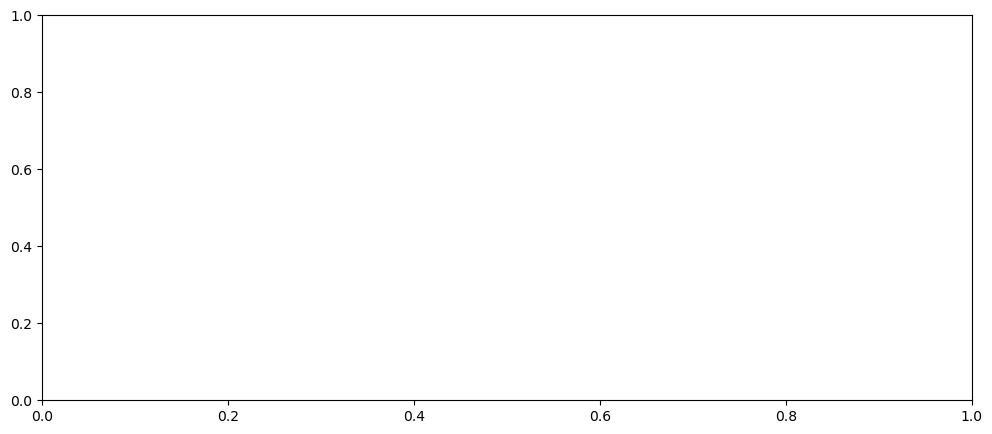

In [7]:
# ============================================================
# 表示: NAV / パフォーマンス / ウェイト
# ============================================================
print("=== NAV時系列（head/tail）===")
display(nav_df.head())
display(nav_df.tail())

print("=== パフォーマンス（Train/Test/All）===")
show_cols = ["strategy_id", "period", "CAGR", "Sharpe", "Vol", "MDD", "AvgTurnover", "TotalCost", "FinalNAV"]
display(perf[show_cols].sort_values(["period", "Sharpe"], ascending=[True, False]))

plt.figure(figsize=(12, 5))
for c in nav_df.columns:
    plt.plot(nav_df.index, nav_df[c], label=c, linewidth=1.5)
plt.title("NAV Comparison")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for c in nav_df.columns:
    plt.plot(nav_df.index, nav_df[c], label=c, linewidth=1.2)
plt.yscale("log")
plt.title("NAV Comparison (log)")
plt.xlabel("Date")
plt.ylabel("NAV (log)")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

dd = nav_df.div(nav_df.cummax()).sub(1.0)
plt.figure(figsize=(12, 5))
for c in dd.columns:
    plt.plot(dd.index, dd[c], label=c, linewidth=1.2)
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("=== 各時点ウェイト（tail 10）===")
for sid, w in weights_by_strategy.items():
    print(f"\n[{sid}] sum(weight) tail:")
    display(w.sum(axis=1).tail(10).to_frame("weight_sum"))
    print(f"[{sid}] weights tail(10):")
    display(w.tail(10))

print("=== 最新日の上位ウェイト ===")
for sid, w in weights_by_strategy.items():
    latest = w.iloc[-1].sort_values(ascending=False)
    print(f"\n[{sid}] latest top-8")
    display(latest.head(8).to_frame("weight"))


=== factor attribution head ===


date strategy_id factor_name      beta
0 2018-02-28         EQW         EQW  0.999818
1 2018-02-28         EQW         IEF -0.000768
2 2018-03-31         EQW         EQW  0.999705
3 2018-03-31         EQW         IEF -0.000777
4 2018-04-30         EQW         EQW  0.999696

date strategy_id factor_name   contrib
0 2018-02-28         EQW         EQW -0.030058
1 2018-02-28         EQW         IEF  0.000007
2 2018-03-31         EQW         EQW -0.011081
3 2018-03-31         EQW         IEF -0.000009
4 2018-04-30         EQW         EQW -0.008909

date strategy_id     alpha     resid
0 2018-02-28         EQW -0.000509  0.000071
1 2018-03-31         EQW -0.000507  0.000035
2 2018-04-30         EQW -0.000507 -0.000153
3 2018-05-31         EQW -0.000513 -0.000171
4 2018-06-30         EQW -0.000518  0.000028

=== internal attribution head ===


date     R_sel    R_port  R_wgt strategy_id
0 2015-01-31 -0.002603 -0.002603    0.0         EQW
1 2015-02-28  0.078360  0.078360    0.0         EQW
2 2015-03-31  0.006712  0.006712    0.0         EQW
3 2015-04-30  0.026100  0.026100    0.0         EQW
4 2015-05-31  0.009224  0.009224    0.0         EQW

=== overlay attribution head ===


date                 managed_strategy_id base_strategy_id  overlay_excess  indicator  eta   M      method
0 2015-01-31  T1_best_onoff_statepred_M12_eta0p2           T1_mom             0.0        0.0  0.2  12  state_pred
1 2015-02-28  T1_best_onoff_statepred_M12_eta0p2           T1_mom             0.0        0.0  0.2  12  state_pred
2 2015-03-31  T1_best_onoff_statepred_M12_eta0p2           T1_mom             0.0        0.0  0.2  12  state_pred
3 2015-04-30  T1_best_onoff_statepred_M12_eta0p2           T1_mom             0.0        0.0  0.2  12  state_pred
4 2015-05-31  T1_best_onoff_statepred_M12_eta0p2           T1_mom             0.0        0.0  0.2  12  state_pred

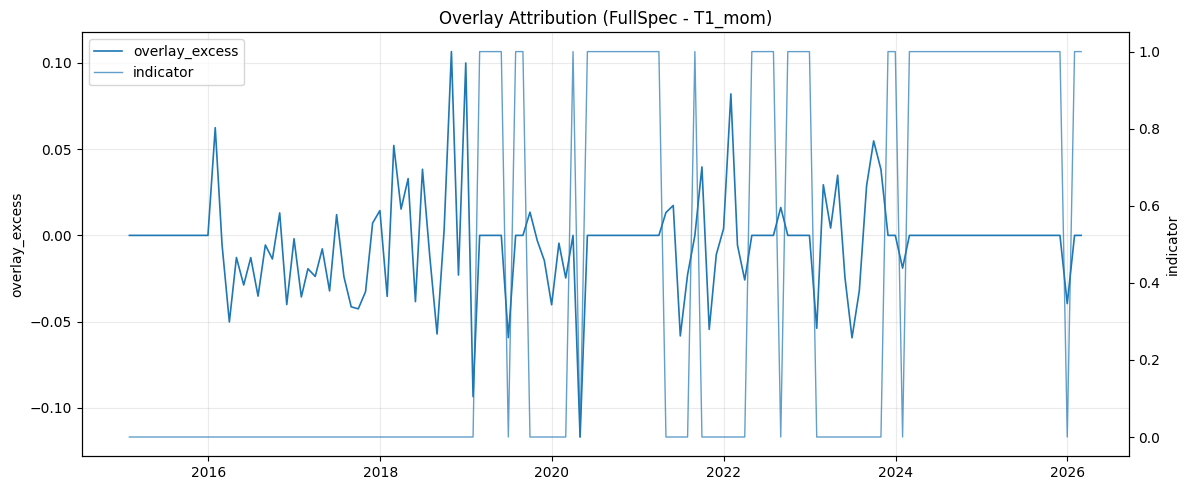

In [ ]:
# ============================================================
# 寄与分析: factor / internal / overlay
# ============================================================
# 1) factor attribution (monthly, EQW + IEF)
def monthly_compound(series: pd.Series) -> pd.Series:
    out = series.groupby(series.index.to_period("M")).apply(
        lambda x: np.nan if x.dropna().empty else (1.0 + x.dropna()).prod() - 1.0
    )
    out.index = out.index.to_timestamp("M")
    return out

ret_m = pd.concat(
    [
        make_monthly_returns_from_nav(nav_df["EQW"]).rename("EQW"),
        make_monthly_returns_from_nav(nav_df["T1_mom"]).rename("T1_mom"),
        make_monthly_returns_from_nav(nav_df["T1_best_onoff_statepred_M12_eta0p2"]).rename("T1_best_onoff_statepred_M12_eta0p2"),
    ],
    axis=1,
)

factor_m = pd.DataFrame(index=ret_m.index)
factor_m["EQW"] = monthly_compound(bundle["eqw_factor"]).reindex(ret_m.index)
factor_m["IEF"] = monthly_compound(bundle["factor_returns"]["IEF"]).reindex(ret_m.index)

betas_df, contrib_df, alpha_df, resid_df = rolling_factor_attribution(
    returns_by_strategy=ret_m,
    factor_returns=factor_m,
    window_months=36,
    lag=1,
)

print("=== factor attribution head ===")
display(betas_df.head())
display(contrib_df.head())
display(alpha_df.head())

plt.figure(figsize=(12, 5))
if not betas_df.empty:
    be = betas_df[betas_df["factor_name"] == "EQW"].pivot(index="date", columns="strategy_id", values="beta").sort_index()
    for sid in be.columns:
        plt.plot(be.index, be[sid], label=sid, linewidth=1.2)
    plt.legend()
plt.title("Rolling Beta to EQW")
plt.xlabel("Date")
plt.ylabel("beta_EQW")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# 2) internal attribution
internal_rows = []
for sid, w in weights_by_strategy.items():
    ia = internal_selection_weighting_attribution(w, bundle["returns"], top_k=cfg.top_k)
    ia["strategy_id"] = sid
    internal_rows.append(ia)
internal_df = pd.concat(internal_rows, ignore_index=True)

print("=== internal attribution head ===")
display(internal_df.head())

plt.figure(figsize=(12, 5))
for sid in ["T1_mom", "T1_best_onoff_statepred_M12_eta0p2"]:
    tmp = internal_df[internal_df["strategy_id"] == sid].copy()
    tmp["date"] = pd.to_datetime(tmp["date"])
    tmp = tmp.sort_values("date")
    plt.plot(tmp["date"], tmp["R_sel"], label=f"R_sel_{sid}", linewidth=1.1)
    plt.plot(tmp["date"], tmp["R_wgt"], label=f"R_wgt_{sid}", linewidth=1.1, linestyle="--")
plt.title("Internal Attribution (Selection / Weighting)")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.grid(alpha=0.25)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# 3) overlay attribution (FullSpec vs T1_mom)
overlay_df = overlay_attribution(
    managed_returns=bt_full["strategy_net_returns"],
    base_returns=bt_t1["strategy_net_returns"],
    indicator=indicator_df["indicator"],
    meta={
        "managed_strategy_id": "T1_best_onoff_statepred_M12_eta0p2",
        "base_strategy_id": "T1_mom",
        "eta": cfg.onoff_eta,
        "M": cfg.onoff_target_m,
        "method": "state_pred",
    },
)

print("=== overlay attribution head ===")
display(overlay_df.head())

plt.figure(figsize=(12, 5))
if not overlay_df.empty:
    od = overlay_df.copy()
    od["date"] = pd.to_datetime(od["date"])
    od = od.sort_values("date")
    ax = plt.gca()
    ax.plot(od["date"], od["overlay_excess"], label="overlay_excess", linewidth=1.2)
    ax.set_ylabel("overlay_excess")
    ax.grid(alpha=0.25)
    ax2 = ax.twinx()
    ax2.plot(od["date"], od["indicator"], label="indicator", linewidth=1.0, alpha=0.7)
    ax2.set_ylabel("indicator")
    l1, lb1 = ax.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax.legend(l1 + l2, lb1 + lb2, loc="upper left")
plt.title("Overlay Attribution (FullSpec - T1_mom)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()
